In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

In [ ]:
# Import required libraries
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# data from drive
VIDEO_FOLDER_PATH = '/content/drive/MyDrive/augmented_dataset'
FRAME_OUTPUT_PATH = '/content/path_to_save_extracted_frames'
DATA_PATH = FRAME_OUTPUT_PATH
ACTIONS = np.array(['Absent', 'Bacteria', 'Beautiful', 'Cabbage', 'Call', 'Enemy', 'Face', 'Fall', 'Happy', 'Luck'])
SEQUENCE_LENGTH = 30
LABEL_MAP = {label: num for num, label in enumerate(ACTIONS)}

In [ ]:
# MEDIAPIPE INIT
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [ ]:
# ---------------------------- FRAME EXTRACTION (FIXED) ----------------------------
import cv2
import os

os.makedirs(FRAME_OUTPUT_PATH, exist_ok=True)

for root, dirs, files in os.walk(VIDEO_FOLDER_PATH):
    for video_file in files:
        if not video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue

        video_path = os.path.join(root, video_file)
        video_name = os.path.splitext(video_file)[0]
        label = os.path.basename(root)
        video_output_dir = os.path.join(FRAME_OUTPUT_PATH, f"{label}_{video_name}")
        os.makedirs(video_output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            filename = f"{video_name}_frame{frame_idx:04d}.jpg"
            cv2.imwrite(os.path.join(video_output_dir, filename), frame)
            frame_idx += 1
        cap.release()
        print(f"Extracted frames from {video_file} to {video_output_dir}")

print("Frame extraction for all subfolders complete.")


Extracted frames from Bacteria_original.mp4 to /content/path_to_save_extracted_frames/Bacteria_Bacteria_original
Extracted frames from Bacteria_speedup1.2x.mp4 to /content/path_to_save_extracted_frames/Bacteria_Bacteria_speedup1.2x
Extracted frames from Bacteria_slowdown0.8x.mp4 to /content/path_to_save_extracted_frames/Bacteria_Bacteria_slowdown0.8x
Extracted frames from Bacteria_bright.mp4 to /content/path_to_save_extracted_frames/Bacteria_Bacteria_bright
Extracted frames from Bacteria_noise.mp4 to /content/path_to_save_extracted_frames/Bacteria_Bacteria_noise
Extracted frames from Bacteria_flipped.mp4 to /content/path_to_save_extracted_frames/Bacteria_Bacteria_flipped
Extracted frames from Beautiful_original.mp4 to /content/path_to_save_extracted_frames/Beautiful_Beautiful_original
Extracted frames from Beautiful_slowdown0.8x.mp4 to /content/path_to_save_extracted_frames/Beautiful_Beautiful_slowdown0.8x
Extracted frames from Beautiful_speedup1.2x.mp4 to /content/path_to_save_extract

In [ ]:
from collections import Counter
import glob
label_counts = Counter()

for folder in os.listdir(FRAME_OUTPUT_PATH):
    label = folder.split("_")[0]
    image_count = len(glob.glob(os.path.join(FRAME_OUTPUT_PATH, folder, '*.jpg')))
    label_counts[label] += image_count

print("Frame counts per label:")
for label, count in label_counts.items():
    print(f"{label}: {count} frames")



Frame counts per label:
Fall: 432 frames
Enemy: 263 frames
Beautiful: 321 frames
Luck: 350 frames
Call: 275 frames
Absent: 362 frames
Face: 339 frames
Bacteria: 461 frames
Cabbage: 362 frames
Happy: 263 frames


In [ ]:
# ---------------------------- MEDIAPIPE DETECTION ----------------------------
def mediapipe_detection(image, model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False
    results = model.process(image_rgb)
    image_rgb.flags.writeable = True
    return image, results

In [ ]:
# ---------------------------- HAND AXIS ANALYSIS ----------------------------
def calculate_hand_angles(landmarks):
    if landmarks is None:
        return np.zeros(12)
    points = np.array([[lm.x, lm.y] for lm in landmarks.landmark])
    angles = []
    finger_tips = [4, 8, 12, 16, 20]
    finger_bases = [2, 5, 9, 13, 17]
    for tip, base in zip(finger_tips, finger_bases):
        wrist = points[0]
        v1 = points[base] - wrist
        v2 = points[tip] - wrist
        dot = np.dot(v1, v2)
        norm = np.linalg.norm(v1) * np.linalg.norm(v2)
        angle = np.arccos(np.clip(dot / norm, -1.0, 1.0)) if norm > 0 else 0
        angles.append(angle)
    if len(points) > 9:
        angles.append(np.arctan2(*(points[9] - points[0])[::-1]))
    else:
        angles.append(0)
    if len(points) > 17:
        angles.append(np.arctan2(*(points[17] - points[2])[::-1]))
    else:
        angles.append(0)
    if len(points) > 20:
        for tip in finger_tips:
            angles.append(np.linalg.norm(points[tip] - points[0]))
    else:
        angles.extend([0] * 5)
    return np.array(angles)

In [ ]:
def calculate_advanced_hand_features(landmarks):
    if landmarks is None:
        return np.zeros(20)
    points = np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark])
    features = []
    if len(points) > 17:
        v1 = points[2] - points[0]
        v2 = points[17] - points[0]
        normal = np.cross(v1, v2)
        normal = normal / np.linalg.norm(normal) if np.linalg.norm(normal) > 0 else np.zeros(3)
        features.extend(normal)
    else:
        features.extend([0, 0, 0])
    chains = [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16],[17,18,19,20]]
    for ch in chains:
        if all(i < len(points) for i in ch):
            d1 = sum(np.linalg.norm(points[ch[i+1]] - points[ch[i]]) for i in range(len(ch)-1))
            d2 = np.linalg.norm(points[ch[-1]] - points[ch[0]])
            features.append(d1 / (d2 + 1e-6))
        else:
            features.append(1.0)
    if len(points) > 20:
        features.append(np.linalg.norm(points[4] - points[20]))
    else:
        features.append(0)
    if len(points) > 12:
        features.append(np.linalg.norm(points[12] - points[0]))
    else:
        features.append(0)
    tips = [4, 8, 12, 16, 20]
    for i in range(len(tips)-1):
        v1 = points[tips[i]] - points[0]
        v2 = points[tips[i+1]] - points[0]
        dot = np.dot(v1, v2)
        norm = np.linalg.norm(v1) * np.linalg.norm(v2)
        features.append(np.arccos(np.clip(dot / norm, -1.0, 1.0)) if norm > 0 else 0)
    if len(points) > 9 and len(points) > 4:
        axis = points[9] - points[0]
        thumb = points[4] - points[0]
        axis_norm = axis / (np.linalg.norm(axis) + 1e-6)
        thumb_proj = thumb - np.dot(thumb, axis_norm) * axis_norm
        ref = np.array([1, 0, 0])
        features.append(np.arctan2(thumb_proj[1], thumb_proj[0]) if np.linalg.norm(thumb_proj) > 0 else 0)
    else:
        features.append(0)
    return np.array(features[:20])

In [ ]:
def extract_enhanced_keypoints(results):
    pose = np.array([[r.x, r.y, r.z, r.visibility] for r in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh = np.array([[r.x, r.y, r.z] for r in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh = np.array([[r.x, r.y, r.z] for r in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    lh_angles = calculate_hand_angles(results.left_hand_landmarks)
    rh_angles = calculate_hand_angles(results.right_hand_landmarks)
    lh_adv = calculate_advanced_hand_features(results.left_hand_landmarks)
    rh_adv = calculate_advanced_hand_features(results.right_hand_landmarks)
    return np.concatenate([pose, lh, rh, lh_angles, rh_angles, lh_adv, rh_adv])


In [ ]:
# EDA
import os
import matplotlib.pyplot as plt
from collections import defaultdict

frame_counts = defaultdict(int)
sequence_counts = defaultdict(int)
subfolder_counts = defaultdict(list)

print("EDA: Frame and Sequence Overview\n")

# Loop through all subfolders
for folder in sorted(os.listdir(DATA_PATH)):
    folder_path = os.path.join(DATA_PATH, folder)

    # Extract action name from folder name
    for action in ACTIONS:
        if folder.startswith(action):
            frames = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
            num_frames = len(frames)
            num_sequences = num_frames // SEQUENCE_LENGTH

            # Update counts for each frames
            frame_counts[action] += num_frames
            sequence_counts[action] += num_sequences
            subfolder_counts[action].append((folder, num_frames))

            print(f"Subfolder: {folder}")
            print(f"Action: {action}")
            print(f"Frames: {num_frames}")
            print(f"Sequences: {num_sequences}\n")



EDA: Frame and Sequence Overview

Subfolder: Absent_Absent_bright
Action: Absent
Frames: 62
Sequences: 2

Subfolder: Absent_Absent_flipped
Action: Absent
Frames: 62
Sequences: 2

Subfolder: Absent_Absent_noise
Action: Absent
Frames: 62
Sequences: 2

Subfolder: Absent_Absent_original
Action: Absent
Frames: 62
Sequences: 2

Subfolder: Absent_Absent_slowdown0.8x
Action: Absent
Frames: 62
Sequences: 2

Subfolder: Absent_Absent_speedup1.2x
Action: Absent
Frames: 52
Sequences: 1

Subfolder: Bacteria_Bacteria_bright
Action: Bacteria
Frames: 79
Sequences: 2

Subfolder: Bacteria_Bacteria_flipped
Action: Bacteria
Frames: 79
Sequences: 2

Subfolder: Bacteria_Bacteria_noise
Action: Bacteria
Frames: 79
Sequences: 2

Subfolder: Bacteria_Bacteria_original
Action: Bacteria
Frames: 79
Sequences: 2

Subfolder: Bacteria_Bacteria_slowdown0.8x
Action: Bacteria
Frames: 79
Sequences: 2

Subfolder: Bacteria_Bacteria_speedup1.2x
Action: Bacteria
Frames: 66
Sequences: 2

Subfolder: Beautiful_Beautiful_bright
Ac

Summary per Action:
🔹 Absent: 362 frames, 11 sequences across 6 subfolders
🔹 Bacteria: 461 frames, 12 sequences across 6 subfolders
🔹 Beautiful: 321 frames, 6 sequences across 6 subfolders
🔹 Cabbage: 362 frames, 11 sequences across 6 subfolders
🔹 Call: 275 frames, 6 sequences across 6 subfolders
🔹 Enemy: 263 frames, 6 sequences across 6 subfolders
🔹 Face: 339 frames, 6 sequences across 6 subfolders
🔹 Fall: 432 frames, 12 sequences across 6 subfolders
🔹 Happy: 263 frames, 6 sequences across 6 subfolders
🔹 Luck: 350 frames, 11 sequences across 6 subfolders


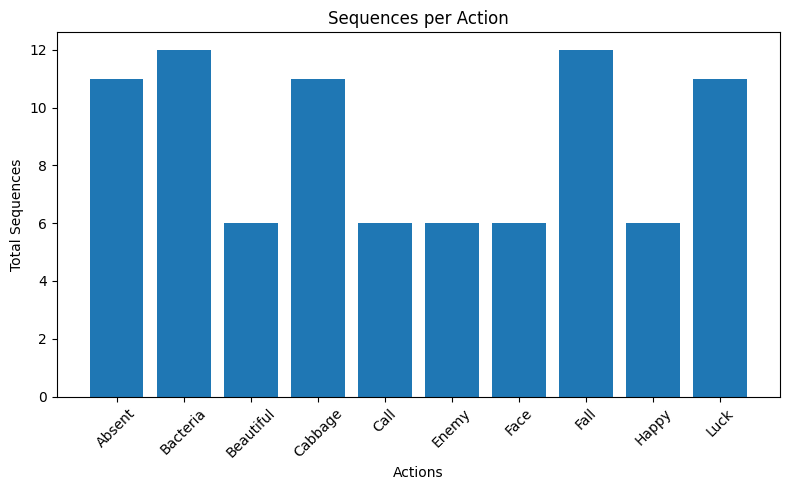

In [ ]:
# Summary
print("Summary per Action:")
for action in ACTIONS:
    print(f"🔹 {action}: {frame_counts[action]} frames, {sequence_counts[action]} sequences across {len(subfolder_counts[action])} subfolders")

plt.figure(figsize=(8,5))
plt.bar(sequence_counts.keys(), sequence_counts.values())
plt.xlabel("Actions")
plt.ylabel("Total Sequences")
plt.title("Sequences per Action")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp

sequences, labels = [], []

# mapping  each action to its subfolders
action_subfolders = {}
for folder in os.listdir(DATA_PATH):
    for action in ACTIONS:
        if folder.startswith(action):
            action_subfolders.setdefault(action, []).append(folder)

for action in ACTIONS:
    print(f"\n Processing Action: {action}")
    for subfolder in action_subfolders.get(action, []):
        action_dir = os.path.join(DATA_PATH, subfolder)
        frames = sorted([f for f in os.listdir(action_dir) if f.endswith('.jpg')])
        total_frames = len(frames)
        num_sequences = total_frames // SEQUENCE_LENGTH

        print(f"Subfolder: {subfolder}")
        print(f"Total Frames: {total_frames}")
        print(f"Usable Sequences (len={SEQUENCE_LENGTH}): {num_sequences}")

        for seq in tqdm(range(num_sequences), desc=f"   → Sequences"):
            window = []
            for frame_num in range(SEQUENCE_LENGTH):
                img_path = os.path.join(action_dir, frames[seq * SEQUENCE_LENGTH + frame_num])
                image = cv2.imread(img_path)

                with mp.solutions.holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as model:
                    results = model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    keypoints = extract_enhanced_keypoints(results)
                    if keypoints.shape != (322,):
                        keypoints = np.zeros(322)
                    window.append(keypoints)

            if len(window) == SEQUENCE_LENGTH:
                sequences.append(np.array(window))
                labels.append(LABEL_MAP[action])
            else:
                print(f"Dropped: {subfolder}, frames collected: {len(window)}")



 Processing Action: Absent
Subfolder: Absent_Absent_slowdown0.8x
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it]


Subfolder: Absent_Absent_original
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


Subfolder: Absent_Absent_speedup1.2x
Total Frames: 52
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Subfolder: Absent_Absent_noise
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:12<00:00,  6.23s/it]


Subfolder: Absent_Absent_flipped
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:16<00:00,  8.45s/it]


Subfolder: Absent_Absent_bright
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.79s/it]



 Processing Action: Bacteria
Subfolder: Bacteria_Bacteria_slowdown0.8x
Total Frames: 79
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.67s/it]


Subfolder: Bacteria_Bacteria_flipped
Total Frames: 79
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.64s/it]


Subfolder: Bacteria_Bacteria_noise
Total Frames: 79
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:14<00:00,  7.31s/it]


Subfolder: Bacteria_Bacteria_original
Total Frames: 79
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.61s/it]


Subfolder: Bacteria_Bacteria_bright
Total Frames: 79
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]


Subfolder: Bacteria_Bacteria_speedup1.2x
Total Frames: 66
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:17<00:00,  8.79s/it]



 Processing Action: Beautiful
Subfolder: Beautiful_Beautiful_slowdown0.8x
Total Frames: 55
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


Subfolder: Beautiful_Beautiful_original
Total Frames: 55
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Subfolder: Beautiful_Beautiful_noise
Total Frames: 55
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]


Subfolder: Beautiful_Beautiful_speedup1.2x
Total Frames: 46
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Subfolder: Beautiful_Beautiful_flipped
Total Frames: 55
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


Subfolder: Beautiful_Beautiful_bright
Total Frames: 55
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  7.00s/it]



 Processing Action: Cabbage
Subfolder: Cabbage_Cabbage_slowdown0.8x
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.67s/it]


Subfolder: Cabbage_Cabbage_bright
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:16<00:00,  8.13s/it]


Subfolder: Cabbage_Cabbage_speedup1.2x
Total Frames: 52
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.58s/it]


Subfolder: Cabbage_Cabbage_noise
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:14<00:00,  7.01s/it]


Subfolder: Cabbage_Cabbage_flipped
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.85s/it]


Subfolder: Cabbage_Cabbage_original
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.85s/it]



 Processing Action: Call
Subfolder: Call_Call_slowdown0.8x
Total Frames: 47
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Subfolder: Call_Call_speedup1.2x
Total Frames: 40
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


Subfolder: Call_Call_original
Total Frames: 47
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


Subfolder: Call_Call_flipped
Total Frames: 47
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Subfolder: Call_Call_noise
Total Frames: 47
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Subfolder: Call_Call_bright
Total Frames: 47
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]



 Processing Action: Enemy
Subfolder: Enemy_Enemy_flipped
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Subfolder: Enemy_Enemy_slowdown0.8x
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]


Subfolder: Enemy_Enemy_bright
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


Subfolder: Enemy_Enemy_noise
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.18s/it]


Subfolder: Enemy_Enemy_original
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


Subfolder: Enemy_Enemy_speedup1.2x
Total Frames: 38
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]



 Processing Action: Face
Subfolder: Face_Face_slowdown0.8x
Total Frames: 58
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


Subfolder: Face_Face_original
Total Frames: 58
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


Subfolder: Face_Face_bright
Total Frames: 58
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]


Subfolder: Face_Face_flipped
Total Frames: 58
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


Subfolder: Face_Face_speedup1.2x
Total Frames: 49
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


Subfolder: Face_Face_noise
Total Frames: 58
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]



 Processing Action: Fall
Subfolder: Fall_Fall_slowdown0.8x
Total Frames: 74
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.73s/it]


Subfolder: Fall_Fall_flipped
Total Frames: 74
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.65s/it]


Subfolder: Fall_Fall_speedup1.2x
Total Frames: 62
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.68s/it]


Subfolder: Fall_Fall_bright
Total Frames: 74
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.68s/it]


Subfolder: Fall_Fall_original
Total Frames: 74
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:16<00:00,  8.14s/it]


Subfolder: Fall_Fall_noise
Total Frames: 74
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:13<00:00,  6.71s/it]



 Processing Action: Happy
Subfolder: Happy_Happy_speedup1.2x
Total Frames: 38
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


Subfolder: Happy_Happy_flipped
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


Subfolder: Happy_Happy_original
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


Subfolder: Happy_Happy_bright
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Subfolder: Happy_Happy_noise
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


Subfolder: Happy_Happy_slowdown0.8x
Total Frames: 45
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]



 Processing Action: Luck
Subfolder: Luck_Luck_bright
Total Frames: 60
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:16<00:00,  8.39s/it]


Subfolder: Luck_Luck_speedup1.2x
Total Frames: 50
Usable Sequences (len=30): 1


   → Sequences: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


Subfolder: Luck_Luck_slowdown0.8x
Total Frames: 60
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.72s/it]


Subfolder: Luck_Luck_original
Total Frames: 60
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.66s/it]


Subfolder: Luck_Luck_noise
Total Frames: 60
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:12<00:00,  6.41s/it]


Subfolder: Luck_Luck_flipped
Total Frames: 60
Usable Sequences (len=30): 2


   → Sequences: 100%|██████████| 2/2 [00:15<00:00,  7.71s/it]


In [ ]:
from collections import defaultdict
import random

max_sequences = max(sequence_counts.values())
balanced_sequences = []
balanced_labels = []

seq_dict = defaultdict(list)

# Group sequences by label
for seq, label in zip(sequences, labels):
    seq_dict[label].append(seq)

# Oversample each class
for label in seq_dict:
    seqs = seq_dict[label]
    needed = max_sequences - len(seqs)
    if needed > 0:
        extra = random.choices(seqs, k=needed)
        seqs += extra
    balanced_sequences.extend(seqs)
    balanced_labels.extend([label] * len(seqs))




In [ ]:
# Final balanced dataset
sequences = np.array(balanced_sequences)
labels = np.array(balanced_labels)

print("Oversampling complete. New shape:", sequences.shape, labels.shape)

Oversampling complete. New shape: (120, 30, 322) (120,)


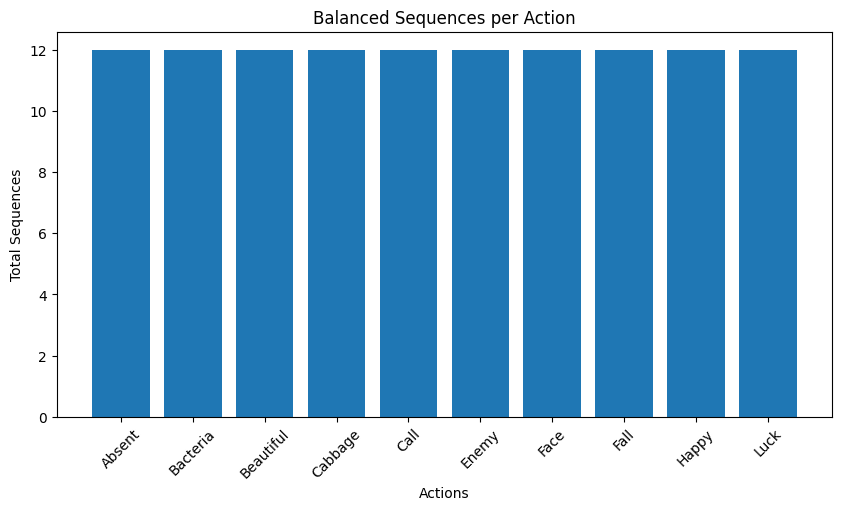

In [ ]:
import matplotlib.pyplot as plt
# balanced by oversampling
balanced_counts = Counter([list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(lbl)] for lbl in labels])

plt.figure(figsize=(10,5))
plt.bar(balanced_counts.keys(), balanced_counts.values())
plt.title("Balanced Sequences per Action")
plt.xlabel("Actions")
plt.ylabel("Total Sequences")
plt.xticks(rotation=45)
plt.show()


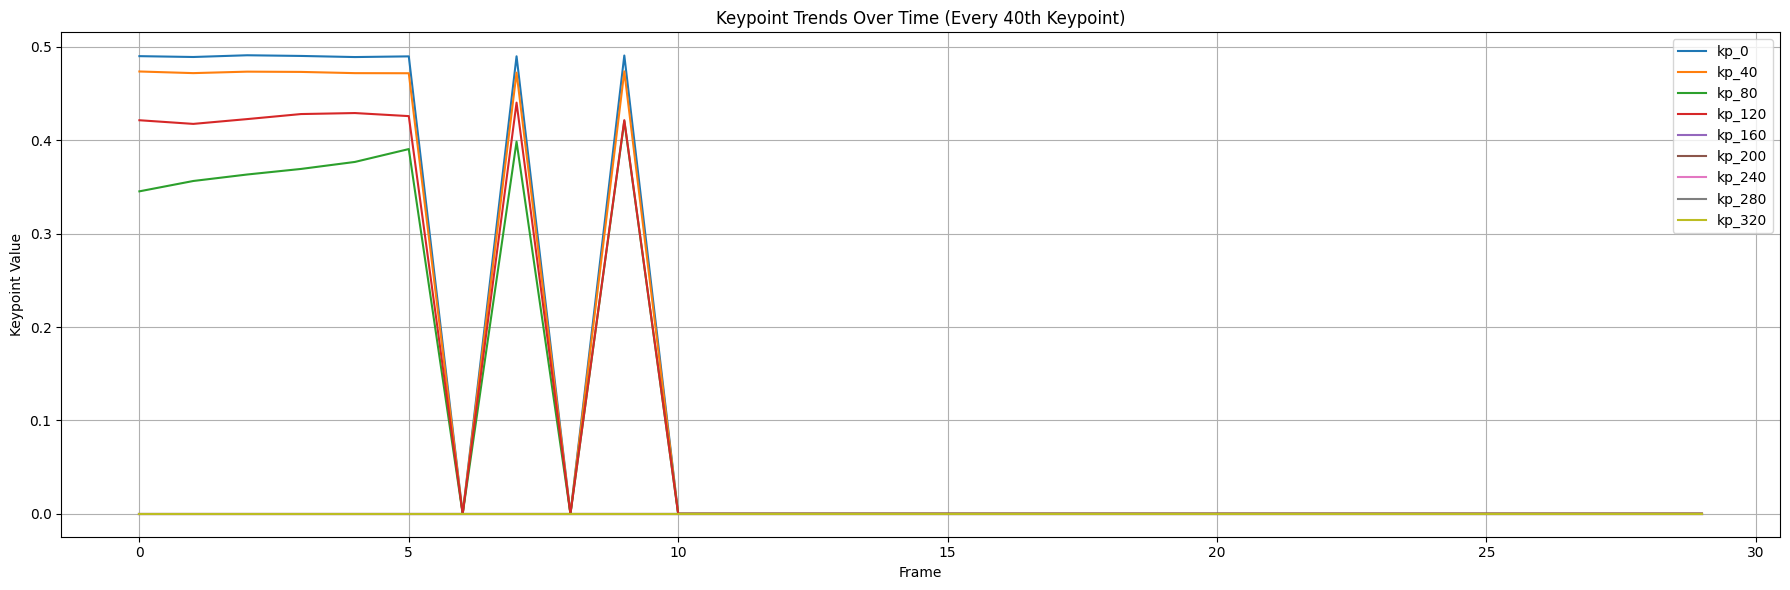

In [ ]:

sample_idx = np.where(labels == 0)[0][0]
sample_sequence = sequences[sample_idx]

plt.figure(figsize=(18, 6))
for i in range(0, 322, 40):
    plt.plot(sample_sequence[:, i], label=f'kp_{i}')

plt.title("Keypoint Trends Over Time (Every 40th Keypoint)")
plt.xlabel("Frame")
plt.ylabel("Keypoint Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


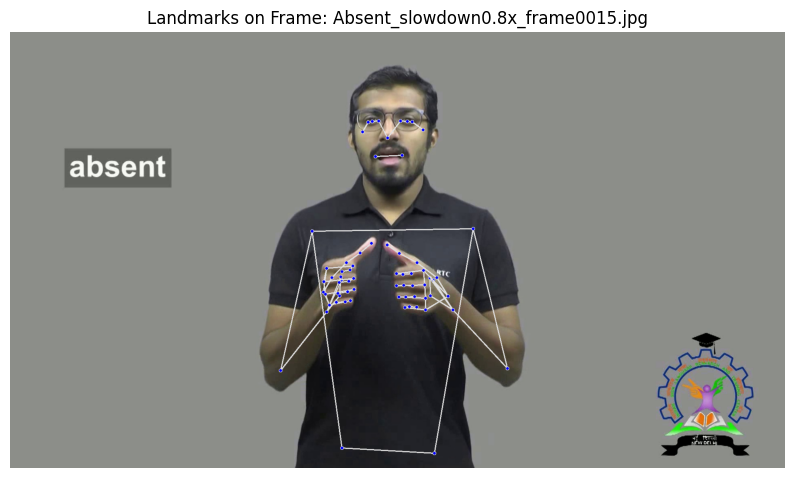

In [ ]:
import cv2
import matplotlib.pyplot as plt



# Load one image
sample_action = ACTIONS[0] # action no onne according to dir
sample_folder = [f for f in os.listdir(DATA_PATH) if f.startswith(sample_action)][0]
sample_path = os.path.join(DATA_PATH, sample_folder)

# pick a random frame
frame_file = sorted([f for f in os.listdir(sample_path) if f.endswith('.jpg')])[15]
frame_path = os.path.join(sample_path, frame_file)

image = cv2.imread(frame_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Run holistic model to get landmarks
with mp_holistic.Holistic(static_image_mode=True) as holistic:
    results = holistic.process(image_rgb)

#Draw landmarks on image
annotated_image = image_rgb.copy()

mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
mp_drawing.draw_landmarks(annotated_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
mp_drawing.draw_landmarks(annotated_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

#Show the image
plt.figure(figsize=(10, 8))
plt.imshow(annotated_image)
plt.title(f"Landmarks on Frame: {frame_file}")
plt.axis('off')
plt.show()


In [ ]:
X = np.array(sequences, dtype=np.float32)
y = to_categorical(labels).astype(np.int32)

In [ ]:
np.save('X_data.npy', X)
np.save('y_labels.npy', y)

In [ ]:
print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")

Final X shape: (120, 30, 322)
Final y shape: (120, 10)


In [ ]:
X = np.load("/content/X_data.npy")
y = np.load("/content/y_labels.npy")

print("X and y loaded from .npy files.")

X and y loaded from .npy files.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(f"Data Ready: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")


Data Ready: X_train: (90, 30, 322), y_train: (90, 10), X_test: (30, 30, 322), y_test: (30, 10)


In [ ]:
for i in range(11):
  print("Sample label:", np.argmax(y_train[i]))
  print("Sample frame feature shape:", X_train[i].shape)

Sample label: 1
Sample frame feature shape: (30, 322)
Sample label: 5
Sample frame feature shape: (30, 322)
Sample label: 0
Sample frame feature shape: (30, 322)
Sample label: 9
Sample frame feature shape: (30, 322)
Sample label: 0
Sample frame feature shape: (30, 322)
Sample label: 4
Sample frame feature shape: (30, 322)
Sample label: 9
Sample frame feature shape: (30, 322)
Sample label: 0
Sample frame feature shape: (30, 322)
Sample label: 0
Sample frame feature shape: (30, 322)
Sample label: 2
Sample frame feature shape: (30, 322)
Sample label: 1
Sample frame feature shape: (30, 322)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

model = Sequential()

# First LSTM layer with regularization
model.add(LSTM(256, return_sequences=True, input_shape=(30, 322),
               kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout after first LSTM to prevent overfitting

# Second LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout after second LSTM

# Third LSTM layer
model.add(LSTM(64, return_sequences=False,
               kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.1))  # Dropout after final LSTM

# Dense layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.1))  # Dropout after dense layer

# Output layer
num_classes = 10
model.add(Dense(num_classes, activation='softmax'))

# Optimizer
optimizer = Adam(learning_rate=1e-4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 256)        │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846,026 (3.23 MB)

 Trainable params: 845,130 (3.22 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - categorical_accuracy: 0.0803 - loss: 3.1278 - val_categorical_accuracy: 0.0333 - val_loss: 2.8275
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.1458 - loss: 2.9247 - val_categorical_accuracy: 0.0667 - val_loss: 2.8229
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.3227 - loss: 2.5347 - val_categorical_accuracy: 0.0333 - val_loss: 2.8172
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.3107 - loss: 2.5106 - val_categorical_accuracy: 0.1000 - val_loss: 2.8095
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3095 - loss: 2.3535 - val_categorical_accuracy: 0.1333 - val_loss: 2.8028
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3038 - loss: 2.4432 - val_categorical_accuracy: 0.1333 - val_loss: 2.7964
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3893 - loss: 2.2217 - v

# Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ------------ Predictions ------------

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


In [ ]:
# ------------ Accuracy ------------

acc = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {acc:.4f}")

# ------------ Classification Report ------------

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

Test Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.43      0.75      0.55         4
           2       0.60      0.75      0.67         4
           3       0.33      0.67      0.44         3
           4       1.00      1.00      1.00         2
           5       1.00      0.67      0.80         3
           6       1.00      0.75      0.86         4
           7       0.50      0.14      0.22         7
           9       1.00      0.50      0.67         2

    accuracy                           0.60        30
   macro avg       0.71      0.69      0.65        30
weighted avg       0.67      0.60      0.59        30



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


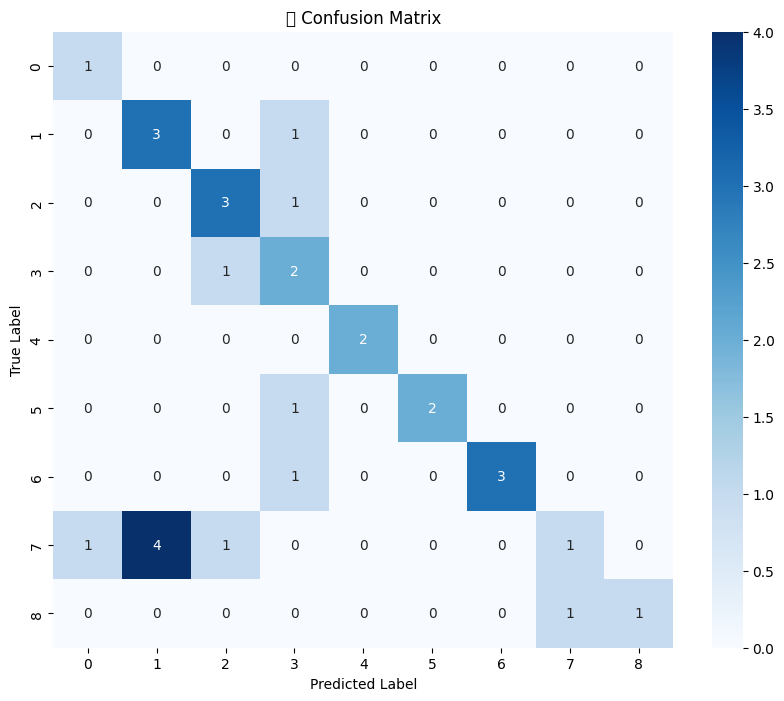

In [ ]:
# ------------ Confusion Matrix ------------

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.title("🧾 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


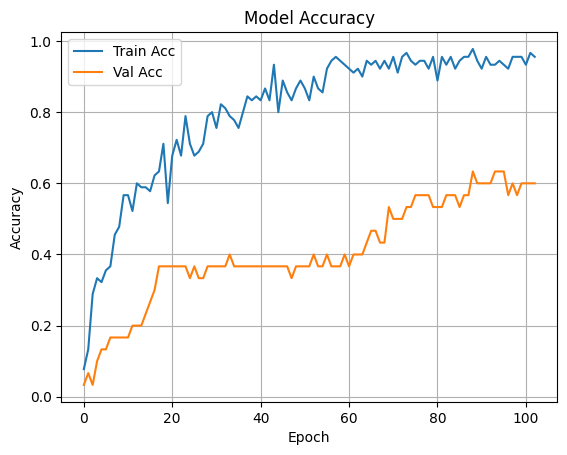

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save model
model.save("best_lstm_sign_model.h5")